In [3]:
import SimCLR
import torch
import rrrc_cpp
import time
import cv2
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/artl2sch/.local/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/artl2sch/.local/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54

In [4]:
import yaml
with open('./config.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

model = SimCLR.load_saved_model(config)
model.to('cuda')
model.eval()

print ("Model loaded")

Model loaded


(1972, 1973)

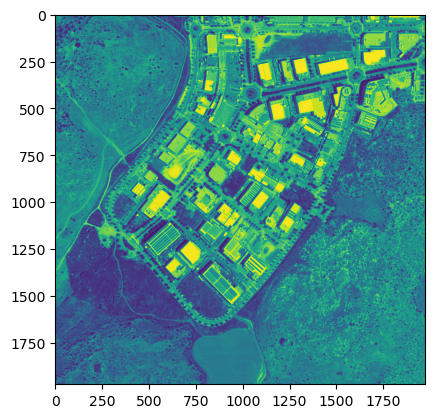

In [5]:
img = cv2.imread("/home/artl2sch/Desktop/Robotic_Perception/C++/FastCropRotate/0-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
img.shape

In [6]:
out_n = 200

input_image  =  torch.tensor(img, dtype = torch.uint8)[None, :, :].contiguous().cuda()
output_images = torch.zeros([out_n, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

M = torch.tensor([1.0, 0.0, 0.0, 1.0]*out_n, dtype = torch.float32)
M_rand = torch.rand_like(M)
M += M_rand * 0.5

M *= input_image.shape[-1]/output_images.shape[-1]
T = torch.tensor([0.0, 0.0]*out_n, dtype = torch.float32)
print ("Prepared Tensors for rrrc")

embeddings = torch.zeros([out_n, 128], dtype = torch.float32).contiguous().cuda()

Prepared Tensors for rrrc


In [7]:

with torch.no_grad():
    for i in range(100):

        t0 = time.time()
        rrrc_cpp.rrrc(input_image, output_images, M, T)
        t1 = time.time()
        
        output_images_3 = output_images.repeat(1, 3, 1, 1)
        embeddings = model(output_images_3)

        t2 = time.time()

        #del output_images_3
        #torch.cuda.empty_cache()

        first_embedding = embeddings[0]
        weights = embeddings - first_embedding

        #del first_embedding
        #torch.cuda.empty_cache()

        weights *= weights
        weights = embeddings.sum(axis = 1)/embeddings.sum()

        #del embeddings
        #torch.cuda.empty_cache()

        new_indices =torch.multinomial(weights, weights.shape[0], replacement=True)

        #del weights
        #torch.cuda.empty_cache()

        t3 = time.time()

        print ("rrrc  time : ", t1 - t0)
        print ("model time : ", t2 - t1)
        print ("samp  time : ", t3 - t2)
        print ("total time : ", t3 - t0)

here
1972 1973 128 128 200
rrrc  time :  0.0018393993377685547
model time :  0.8048017024993896
samp  time :  0.0005967617034912109
total time :  0.8072378635406494
here
1972 1973 128 128 200
rrrc  time :  0.009898900985717773
model time :  0.0023496150970458984
samp  time :  0.00017070770263671875
total time :  0.01241922378540039
here
1972 1973 128 128 200
rrrc  time :  0.04027915000915527
model time :  0.0017421245574951172
samp  time :  0.00017690658569335938
total time :  0.04219818115234375
here
1972 1973 128 128 200
rrrc  time :  0.04085087776184082
model time :  0.0017285346984863281
samp  time :  0.00013399124145507812
total time :  0.04271340370178223
here
1972 1973 128 128 200
rrrc  time :  0.04091310501098633
model time :  0.0016415119171142578
samp  time :  0.00012540817260742188
total time :  0.04268002510070801
here
1972 1973 128 128 200
rrrc  time :  0.04097628593444824
model time :  0.0016143321990966797
samp  time :  0.0001289844512939453
total time :  0.0427196025848

In [42]:
t = time.time()
first_embedding = embeddings[0].clone()
weights = embeddings - first_embedding
weights *= weights
weights = embeddings.sum(axis = 1)/embeddings.sum()
new_indices =torch.multinomial(weights, weights.shape[0], replacement=True)
new_embeddings = embeddings[new_indices]
print (time.time() - t)

0.0009171962738037109
